In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib as plt
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import _LRScheduler
from PIL import Image
from scipy.ndimage import map_coordinates, gaussian_filter
from sklearn.metrics import precision_recall_fscore_support
import shutil
import csv

%run '/kaggle/input/cte-dataloader/CTE.ipynb'
%run '/kaggle/input/cte-dataloader/dataloader.ipynb'


import numpy as np
import os

torch.Size([1, 105])


In [2]:
class LabelSomCE(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self,x,target,smoothing=0.1):
		confidence = 1.0 - smoothing
		logprobs = F.log_softmax(x,dim=-1)
		nll_loss = - logprobs.gather(dim=-1,index=target.unsqueeze(1))
		nll_loss = nll_loss.squeeze(1)
		smooth_loss = -logprobs.mean(dim=-1)
		loss = confidence * nll_loss + smoothing * smooth_loss

		return loss.mean()

def download(folder,thetarfile):
    import urllib.request
    import tarfile
    ftpstream = urllib.request.urlopen(thetarfile)
    thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
    thetarfile.extractall(folder)
    thetarfile.close()

def download_cerug(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/CERUG-EN-test-images.tar.gz"
    download(folder,thetarfile)

def download_firemaker(folder):
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-train-images.tar.gz"
    download(folder,thetarfile)
    thetarfile = "https://www.ai.rug.nl/~sheng/writerset/Firemaker-test-images.tar.gz"
    download(folder,thetarfile)

    
def copy_folder_contents(source_folder, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    for item in os.listdir(source_folder):
        source_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)
        if os.path.isdir(source_path):
            shutil.copytree(source_path, destination_path)
        else:
            shutil.copy2(source_path, destination_path)

In [3]:
class ImageTransformer:
    def __init__(self, foldername, imgtype='png'):
        self.imgtype = imgtype
        self.folder = foldername
        self.imglist = self.get_imgList(self.folder)
        #print(f'Image list: {self.imglist}')
        print(f'Number of images: {len(self.imglist)}')

    def get_imgList(self, folder):
        return [img for img in os.listdir(folder) if img.endswith(self.imgtype)]

    def elastic_transform(self, image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

        x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
        indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
        return distorted_image

    def perspective_transform(self, image):
        width, height = image.size
        coeffs = self.find_coeffs(
            [(0, 0), (width, 0), (width, height), (0, height)],
            [(random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), random.randint(0, height // 4)),
             (width - random.randint(0, width // 4), height - random.randint(0, height // 4)),
             (random.randint(0, width // 4), height - random.randint(0, height // 4))]
        )
        return image.transform((width, height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

    def zoom_out_transform(self, image, scale=0.8):
        width, height = image.size
        new_width, new_height = int(width * scale), int(height * scale)
        return image.resize((new_width, new_height), Image.BICUBIC)

    def find_coeffs(self, pa, pb):
        matrix = []
        for p1, p2 in zip(pa, pb):
            matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0] * p1[0], -p2[0] * p1[1]])
            matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1] * p1[0], -p2[1] * p1[1]])

        A = np.matrix(matrix, dtype=float)
        B = np.array(pb).reshape(8)

        res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
        return np.array(res).reshape(8)

    def process_and_save_images(self):
        for imgfile in self.imglist:
            # Open the image
            image = Image.open(os.path.join(self.folder, imgfile)).convert('L')
            original_image = np.array(image)

            # Save original image
            original_image_filename = os.path.join(self.folder, imgfile)
            image.save(original_image_filename)

            # Elastic distortion
            elastic_image = self.elastic_transform(original_image, alpha=34, sigma=4)
            elastic_image = Image.fromarray(elastic_image).convert('L')
            elastic_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_1.' + self.imgtype)
            elastic_image.save(elastic_image_filename)

            # Perspective transformation
            perspective_image = self.perspective_transform(image)
            perspective_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_2.' + self.imgtype)
            perspective_image.save(perspective_image_filename)

            # Zoom out transformation
            zoom_out_image = self.zoom_out_transform(image, scale=0.8)  # Adjust scale as needed
            zoom_out_image_filename = os.path.join(self.folder, imgfile.split('.')[0] + '_3.' + self.imgtype)
            zoom_out_image.save(zoom_out_image_filename)

Number of images: 22839
wsegs_writer_index_table.pickle
----------
loading dataset /kaggle/input/firemaker-dataset/Firemaker Dataset with images: 91356
number of writer is: 250
-*-*-*-*-*-*-*-*-*-*
wsegs_writer_index_table.pickle
----------
loading dataset /kaggle/input/firemaker-dataset/Firemaker Dataset with images: 11595
number of writer is: 250
-*-*-*-*-*-*-*-*-*-*
Traing epoch: 0   avg loss is: 5.991867888765173
Validation epoch: 0   avg validation loss is: 3.992009057340951
Validating on epoch: 0 has accuracy: top1: 20.87 top5: 47.37


/tmp/ipykernel_23/267643492.py:153: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Validating on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
/tmp/ipykernel_23/267643492.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fp.write('Validating epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))


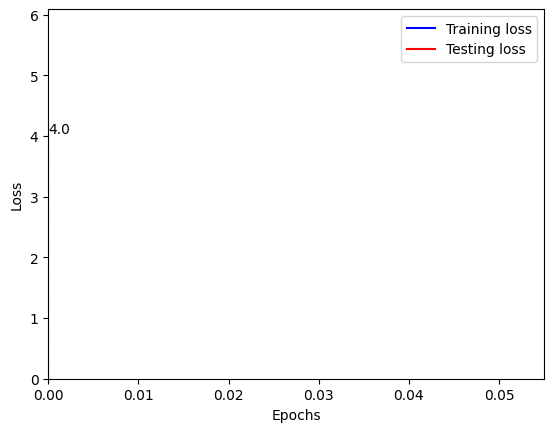

Traing epoch: 1   avg loss is: 3.5059340356381434
Validation epoch: 1   avg validation loss is: 3.1666779863423313
Validating on epoch: 1 has accuracy: top1: 39.40 top5: 71.10


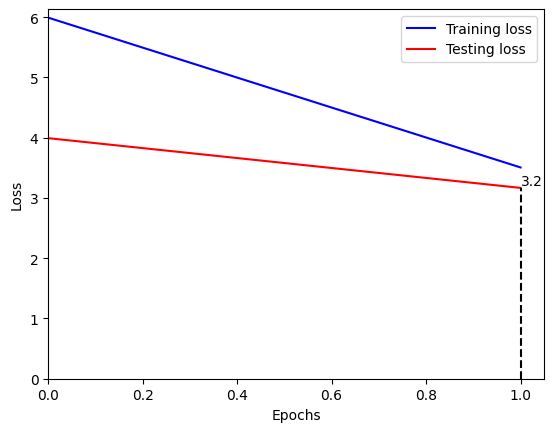

Traing epoch: 2   avg loss is: 2.851221891831007
Validation epoch: 2   avg validation loss is: 2.974836220741272
Validating on epoch: 2 has accuracy: top1: 46.73 top5: 75.19


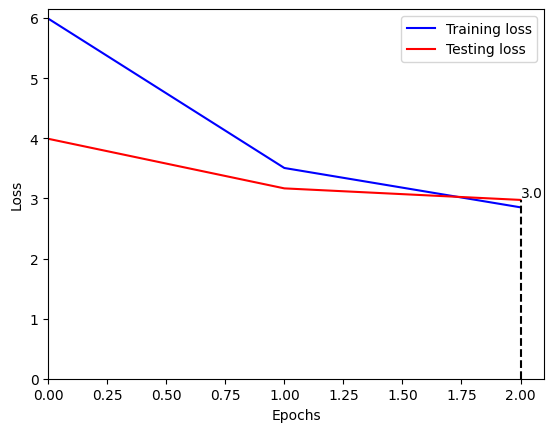

Traing epoch: 3   avg loss is: 2.465415452340581
Validation epoch: 3   avg validation loss is: 2.6821305268386313
Validating on epoch: 3 has accuracy: top1: 55.39 top5: 80.91


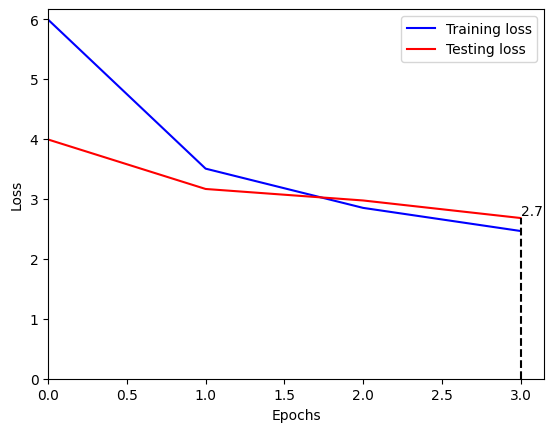

Traing epoch: 4   avg loss is: 2.195985120510884
Validation epoch: 4   avg validation loss is: 2.578372749295728
Validating on epoch: 4 has accuracy: top1: 57.29 top5: 82.80


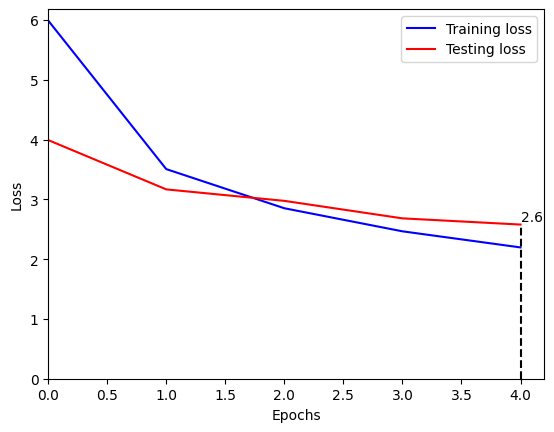

Traing epoch: 5   avg loss is: 1.9979499556968583
Validation epoch: 5   avg validation loss is: 2.421801769980069
Validating on epoch: 5 has accuracy: top1: 61.60 top5: 85.11


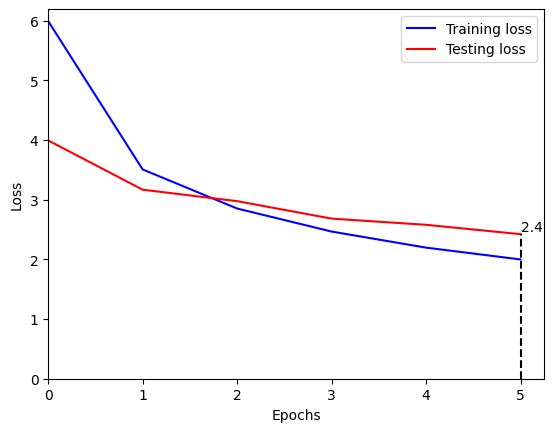

Traing epoch: 6   avg loss is: 1.8312037640516636
Validation epoch: 6   avg validation loss is: 2.394799329001328
Validating on epoch: 6 has accuracy: top1: 62.89 top5: 85.07


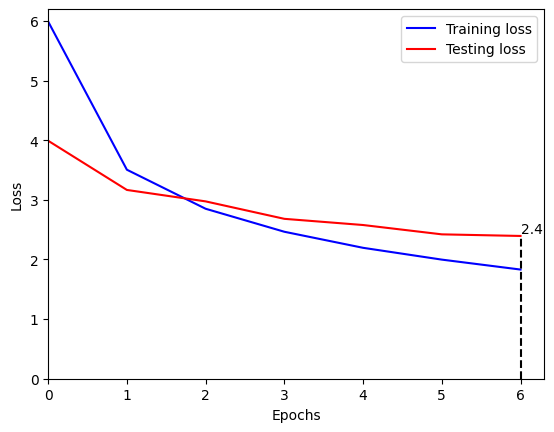

Traing epoch: 7   avg loss is: 1.6957994352645727
Validation epoch: 7   avg validation loss is: 2.2895766613401216
Validating on epoch: 7 has accuracy: top1: 65.15 top5: 86.60


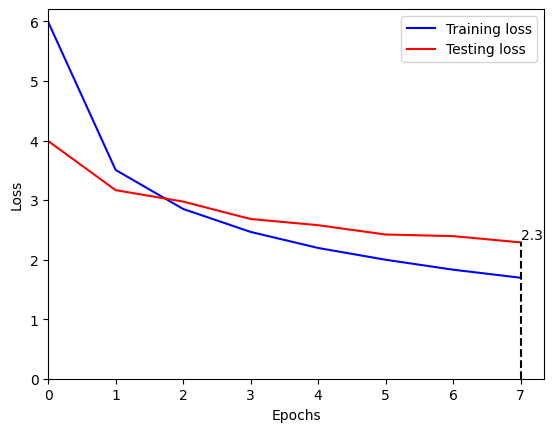

Traing epoch: 8   avg loss is: 1.5905569077456847
Validation epoch: 8   avg validation loss is: 2.4057155084609985
Validating on epoch: 8 has accuracy: top1: 62.16 top5: 84.43


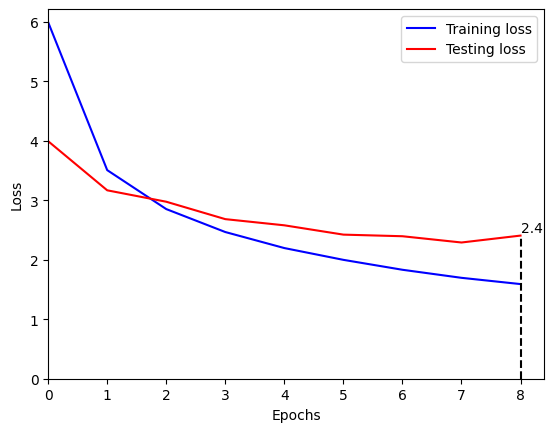

Traing epoch: 9   avg loss is: 1.5028681752560205
Validation epoch: 9   avg validation loss is: 2.329364157380729
Validating on epoch: 9 has accuracy: top1: 64.37 top5: 85.87


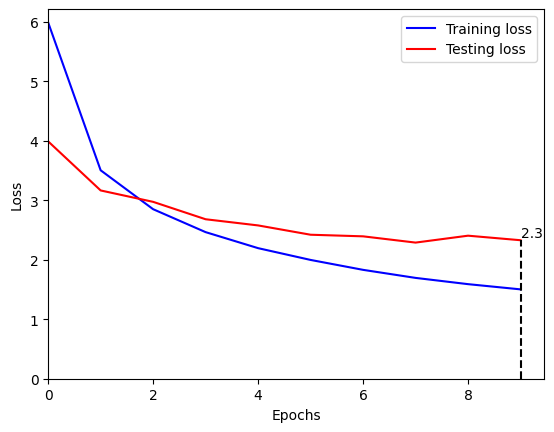

Traing epoch: 10   avg loss is: 1.2783630781487756
Validation epoch: 10   avg validation loss is: 2.1084326512238074
Validating on epoch: 10 has accuracy: top1: 69.92 top5: 88.66


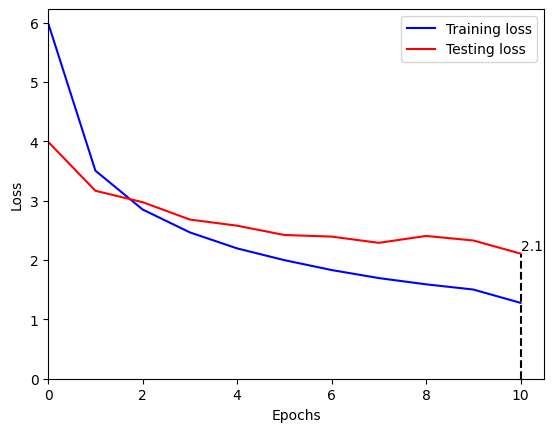

Traing epoch: 11   avg loss is: 1.227245366203741
Validation epoch: 11   avg validation loss is: 1.979966678126105
Validating on epoch: 11 has accuracy: top1: 74.07 top5: 90.10


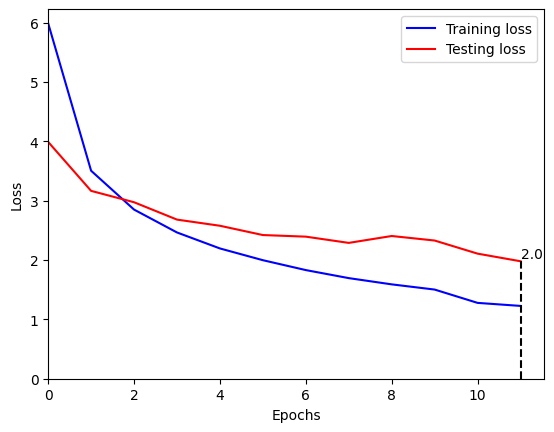

Traing epoch: 12   avg loss is: 1.1927595310399945
Validation epoch: 12   avg validation loss is: 2.0172775720727856
Validating on epoch: 12 has accuracy: top1: 72.32 top5: 89.29


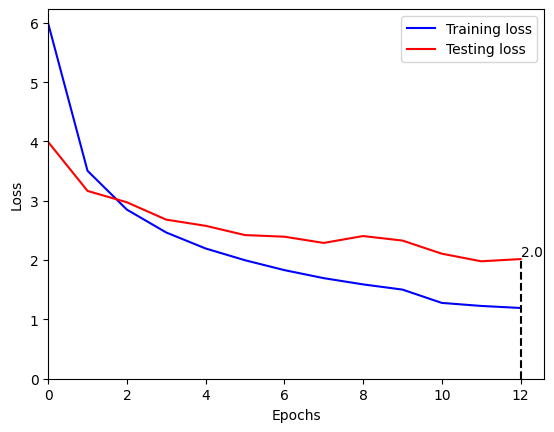

Traing epoch: 13   avg loss is: 1.1663362972789397
Validation epoch: 13   avg validation loss is: 2.0130070554799047
Validating on epoch: 13 has accuracy: top1: 72.80 top5: 89.67


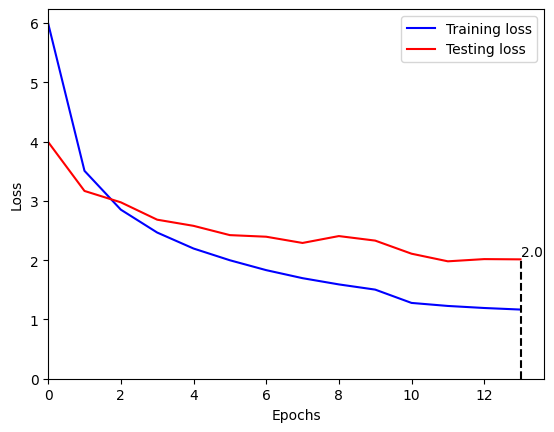

Traing epoch: 14   avg loss is: 1.1434879824375601
Validation epoch: 14   avg validation loss is: 2.038579797744751
Validating on epoch: 14 has accuracy: top1: 72.70 top5: 89.09


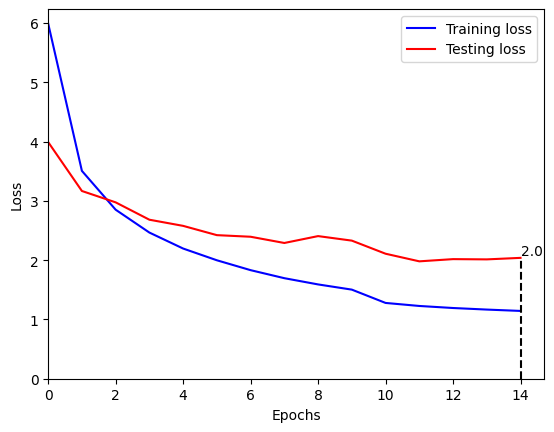

Traing epoch: 15   avg loss is: 1.124759913848106
Validation epoch: 15   avg validation loss is: 1.9831700083305095
Validating on epoch: 15 has accuracy: top1: 73.40 top5: 89.69


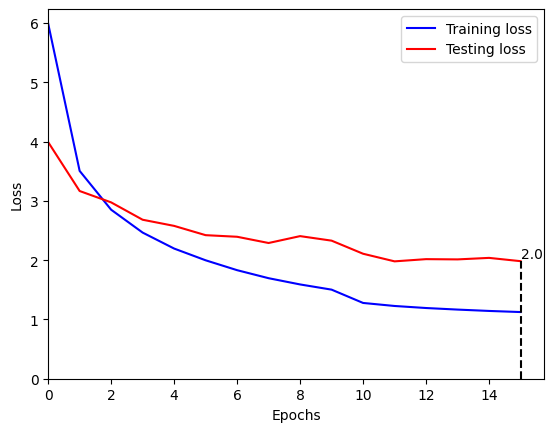

Traing epoch: 16   avg loss is: 1.109279708574983
Validation epoch: 16   avg validation loss is: 2.194282050626031
Validating on epoch: 16 has accuracy: top1: 67.39 top5: 86.82


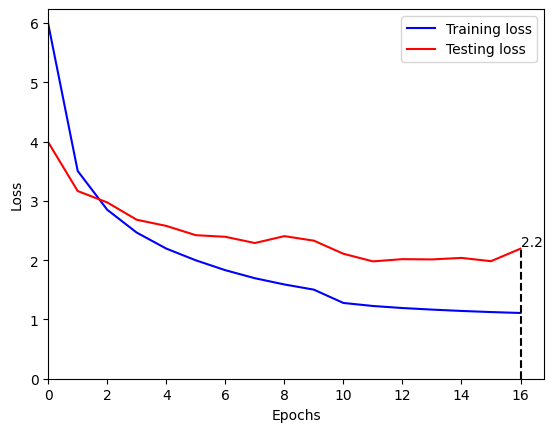

Traing epoch: 17   avg loss is: 1.0948394165291304
Validation epoch: 17   avg validation loss is: 2.0339242922026535
Validating on epoch: 17 has accuracy: top1: 71.59 top5: 88.85


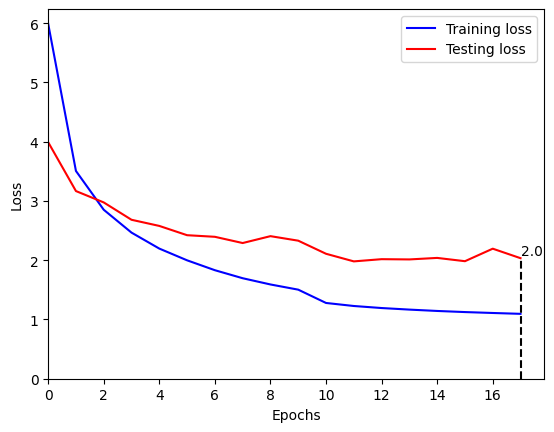

Traing epoch: 18   avg loss is: 1.0837110739536056
Validation epoch: 18   avg validation loss is: 2.0086590166749625
Validating on epoch: 18 has accuracy: top1: 72.74 top5: 89.21


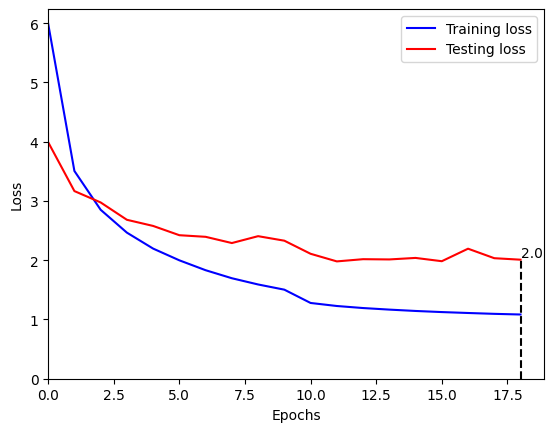

Traing epoch: 19   avg loss is: 1.071740750517689
Validation epoch: 19   avg validation loss is: 2.0796416659190737
Validating on epoch: 19 has accuracy: top1: 70.43 top5: 88.27


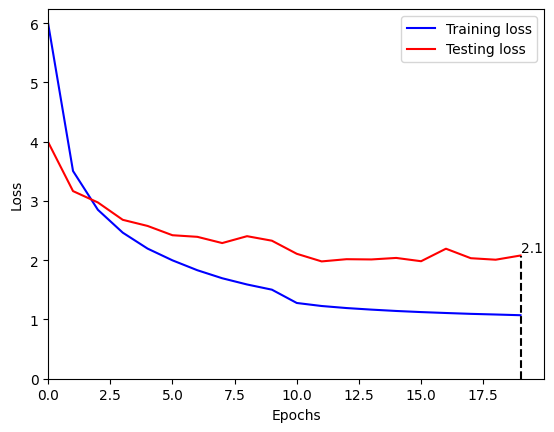

Traing epoch: 20   avg loss is: 1.02090725719793
Validation epoch: 20   avg validation loss is: 1.925225012384612
Validating on epoch: 20 has accuracy: top1: 76.68 top5: 90.82


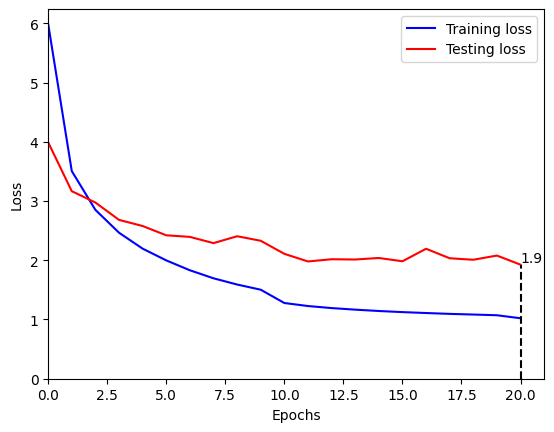

Traing epoch: 21   avg loss is: 1.0092916641600351
Validation epoch: 21   avg validation loss is: 1.9611200330997336
Validating on epoch: 21 has accuracy: top1: 76.82 top5: 90.70


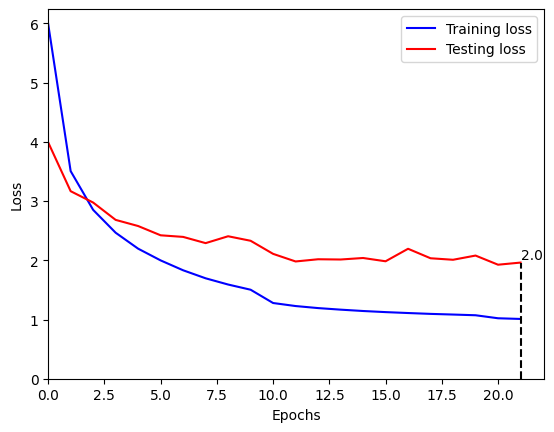

Traing epoch: 22   avg loss is: 1.0019975555488077
Validation epoch: 22   avg validation loss is: 1.9870828835717562
Validating on epoch: 22 has accuracy: top1: 74.94 top5: 90.00


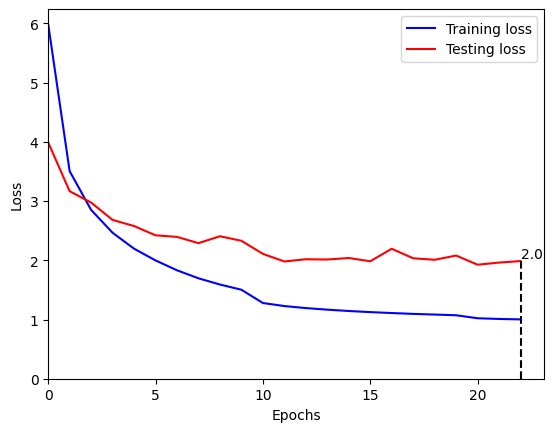

Traing epoch: 23   avg loss is: 0.9965119955313771
Validation epoch: 23   avg validation loss is: 1.9265808253452696
Validating on epoch: 23 has accuracy: top1: 76.56 top5: 90.95


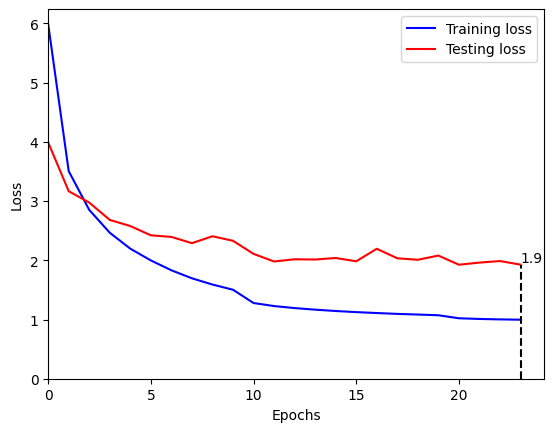

Traing epoch: 24   avg loss is: 0.9916240807839963
Validation epoch: 24   avg validation loss is: 1.932592590923967
Validating on epoch: 24 has accuracy: top1: 77.15 top5: 90.96


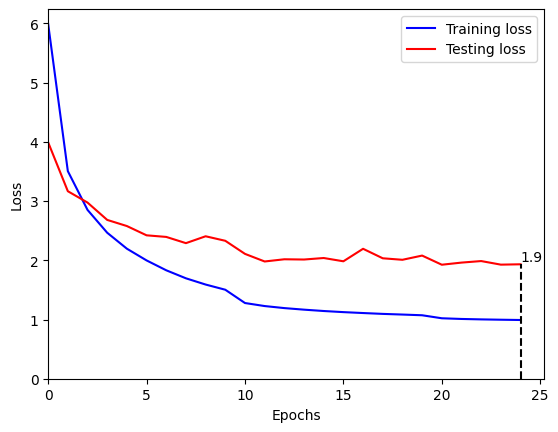

Traing epoch: 25   avg loss is: 0.9876417927450506
Validation epoch: 25   avg validation loss is: 1.9655033154323183
Validating on epoch: 25 has accuracy: top1: 76.23 top5: 90.69


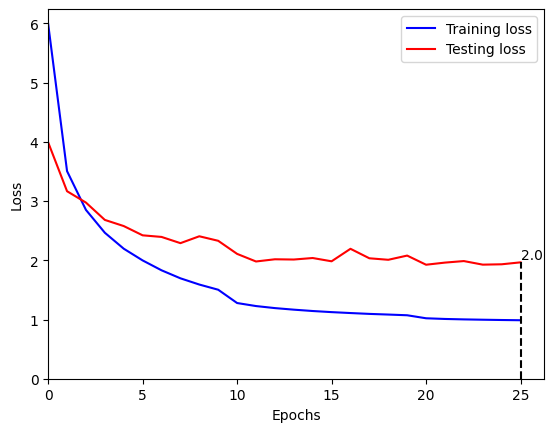

Traing epoch: 26   avg loss is: 0.9838297859259716
Validation epoch: 26   avg validation loss is: 2.025767484040096
Validating on epoch: 26 has accuracy: top1: 75.48 top5: 90.41


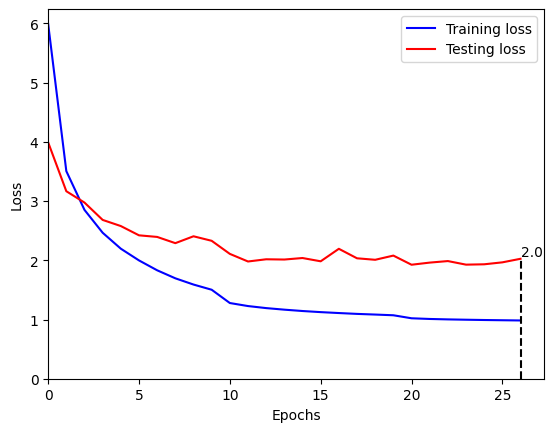

Traing epoch: 27   avg loss is: 0.9806925932754254
Validation epoch: 27   avg validation loss is: 2.0454903115897345
Validating on epoch: 27 has accuracy: top1: 74.33 top5: 89.40


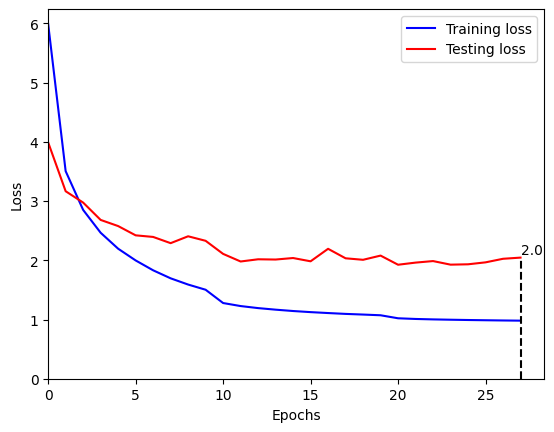

Traing epoch: 28   avg loss is: 0.9776585591321736
Validation epoch: 28   avg validation loss is: 1.9341856764102805
Validating on epoch: 28 has accuracy: top1: 77.39 top5: 91.03


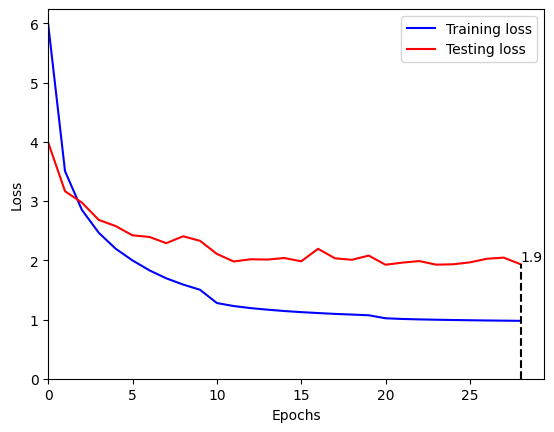

Traing epoch: 29   avg loss is: 0.9744306947767766
Validation epoch: 29   avg validation loss is: 1.9386472777662607
Validating on epoch: 29 has accuracy: top1: 77.27 top5: 90.97


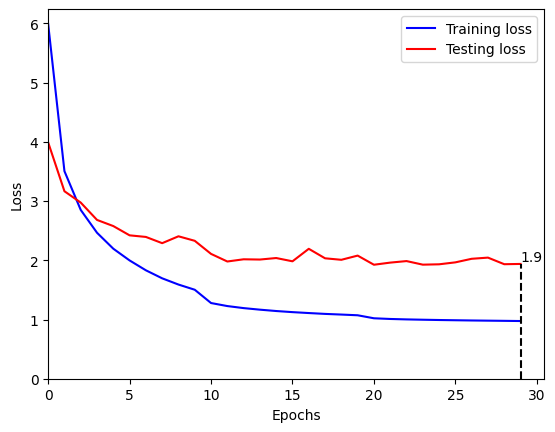

Traing epoch: 30   avg loss is: 0.9582002131820748
Validation epoch: 30   avg validation loss is: 1.9276369251053909
Validating on epoch: 30 has accuracy: top1: 78.43 top5: 91.51


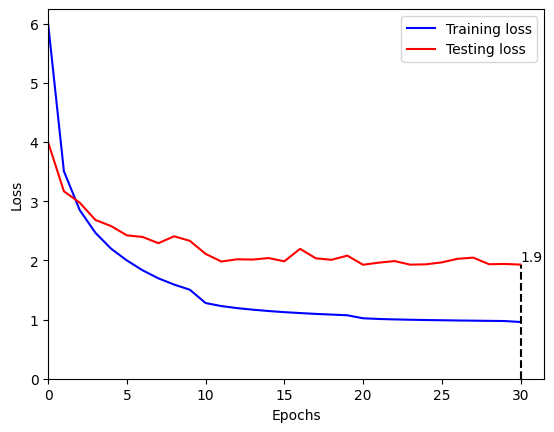

Traing epoch: 31   avg loss is: 0.9537507168756807
Validation epoch: 31   avg validation loss is: 1.9564139203367563
Validating on epoch: 31 has accuracy: top1: 78.13 top5: 91.06


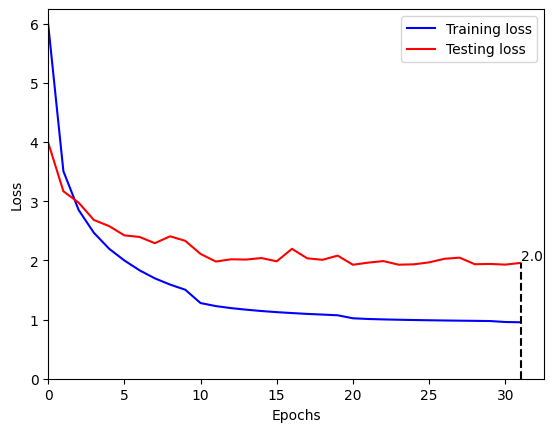

Traing epoch: 32   avg loss is: 0.9516077038076217
Validation epoch: 32   avg validation loss is: 1.9480355976367818
Validating on epoch: 32 has accuracy: top1: 77.84 top5: 91.25


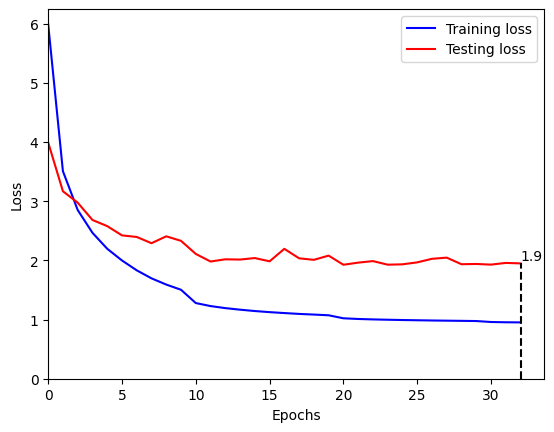

Traing epoch: 33   avg loss is: 0.9493801772625773
Validation epoch: 33   avg validation loss is: 1.938326839907416
Validating on epoch: 33 has accuracy: top1: 78.19 top5: 91.21


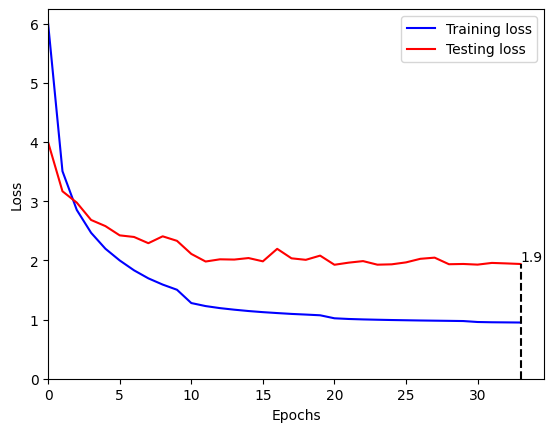

Traing epoch: 34   avg loss is: 0.9478204324567437
Validation epoch: 34   avg validation loss is: 1.9609712686209844
Validating on epoch: 34 has accuracy: top1: 77.34 top5: 91.13


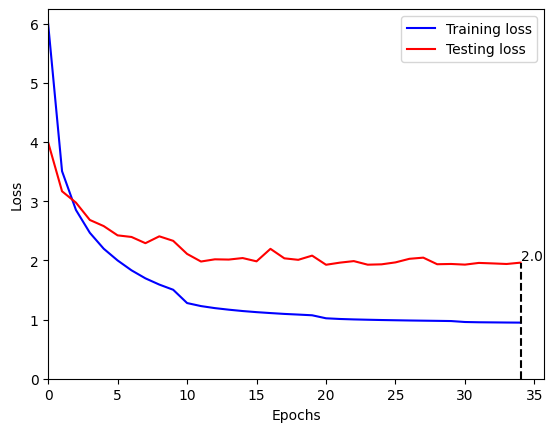

Traing epoch: 35   avg loss is: 0.9461886375375127
Validation epoch: 35   avg validation loss is: 1.9485332666594406
Validating on epoch: 35 has accuracy: top1: 78.17 top5: 91.27


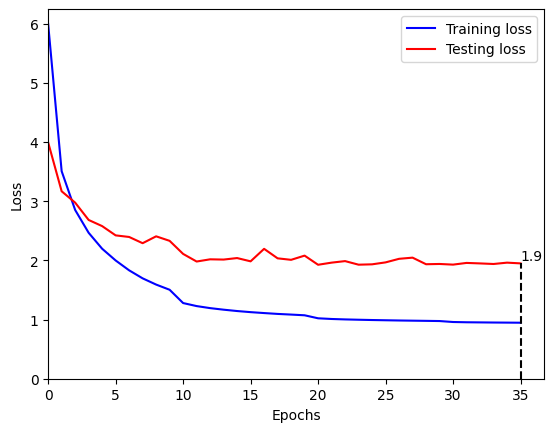

Traing epoch: 36   avg loss is: 0.9448592103619692
Validation epoch: 36   avg validation loss is: 2.0102642236906907
Validating on epoch: 36 has accuracy: top1: 77.12 top5: 91.00


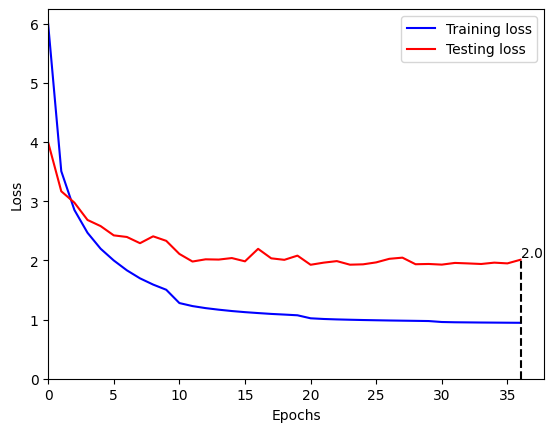

Traing epoch: 37   avg loss is: 0.9436776370441753
Validation epoch: 37   avg validation loss is: 1.9648327725509118
Validating on epoch: 37 has accuracy: top1: 77.87 top5: 91.22


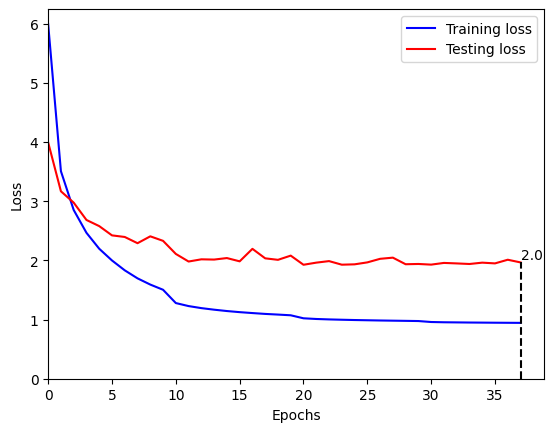

Traing epoch: 38   avg loss is: 0.9422180702732665
Validation epoch: 38   avg validation loss is: 1.962137345116714
Validating on epoch: 38 has accuracy: top1: 77.90 top5: 91.05


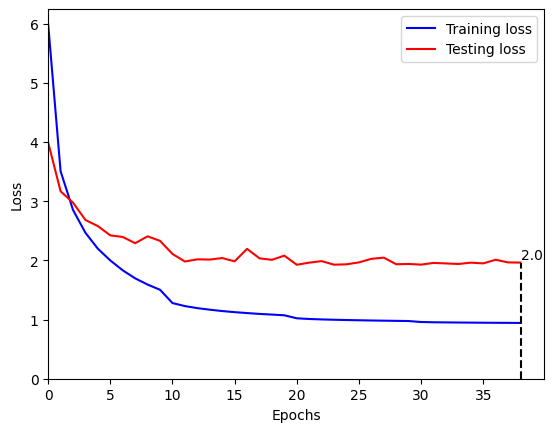

Traing epoch: 39   avg loss is: 0.9409240225209603
Validation epoch: 39   avg validation loss is: 2.0173792189565196
Validating on epoch: 39 has accuracy: top1: 76.88 top5: 90.80


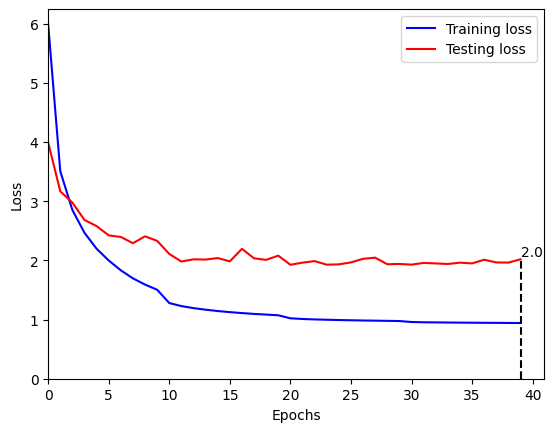

Traing epoch: 40   avg loss is: 0.9349623762865914
Validation epoch: 40   avg validation loss is: 1.9707501589018723
Validating on epoch: 40 has accuracy: top1: 78.23 top5: 91.20


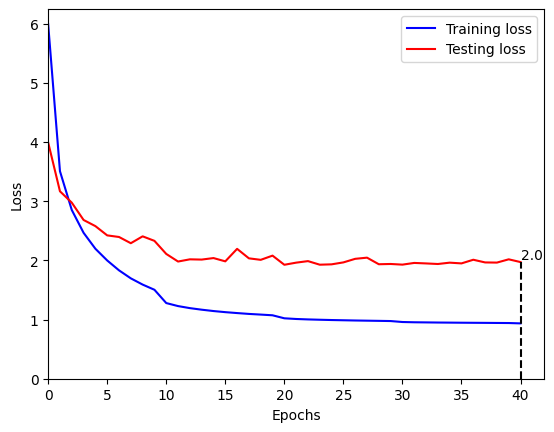

Traing epoch: 41   avg loss is: 0.9334897229291027
Validation epoch: 41   avg validation loss is: 2.016926718909165
Validating on epoch: 41 has accuracy: top1: 77.85 top5: 90.94


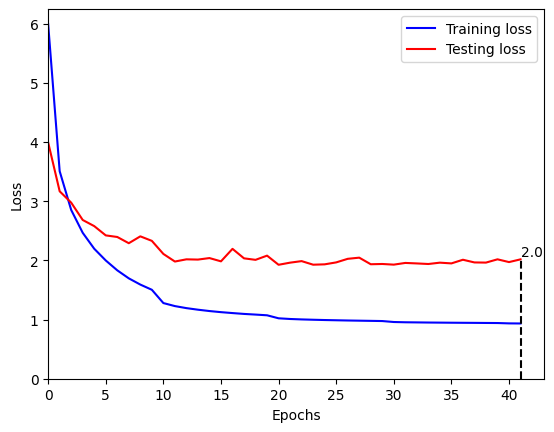

Traing epoch: 42   avg loss is: 0.9323081226957766
Validation epoch: 42   avg validation loss is: 1.9757588772938168
Validating on epoch: 42 has accuracy: top1: 78.02 top5: 91.19


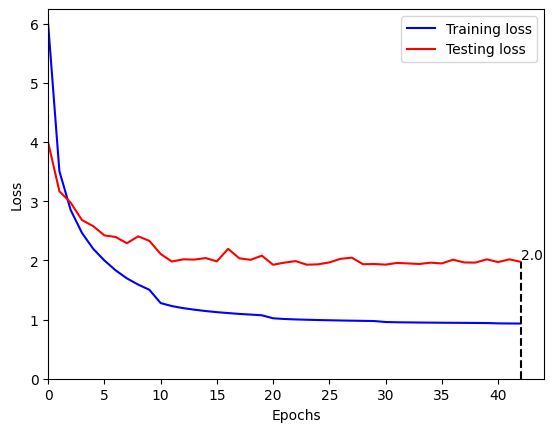

Traing epoch: 43   avg loss is: 0.9314167525016984
Validation epoch: 43   avg validation loss is: 1.9992961280099277
Validating on epoch: 43 has accuracy: top1: 77.93 top5: 91.30


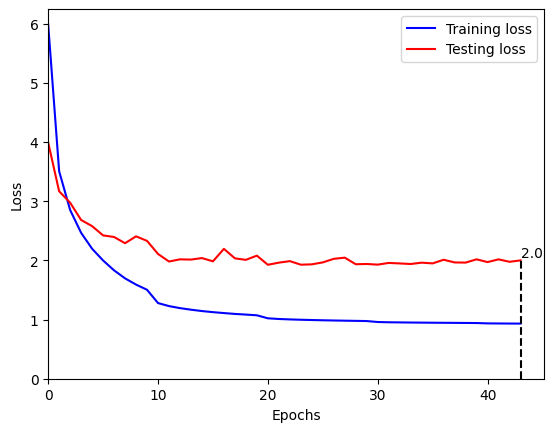

Traing epoch: 44   avg loss is: 0.9307669354604325
Validation epoch: 44   avg validation loss is: 2.0067474444159146
Validating on epoch: 44 has accuracy: top1: 77.50 top5: 91.34


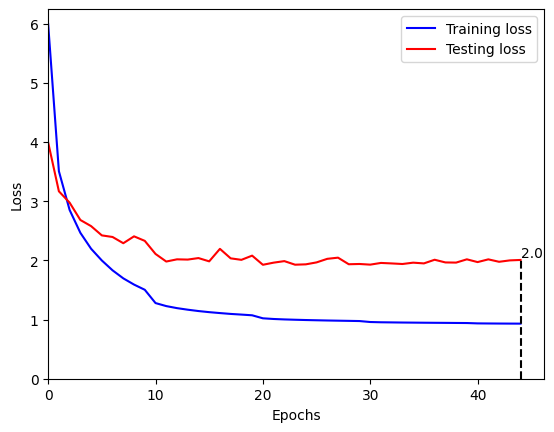

Traing epoch: 45   avg loss is: 0.9301361286258046
Validation epoch: 45   avg validation loss is: 1.9607366458300886
Validating on epoch: 45 has accuracy: top1: 78.33 top5: 91.30


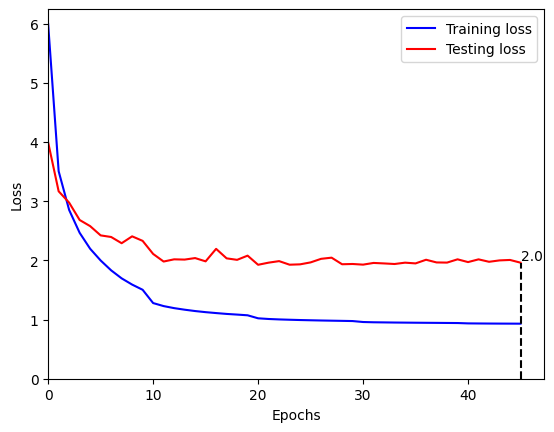

Traing epoch: 46   avg loss is: 0.9293432299926666
Validation epoch: 46   avg validation loss is: 1.9898114656579906
Validating on epoch: 46 has accuracy: top1: 78.15 top5: 91.34


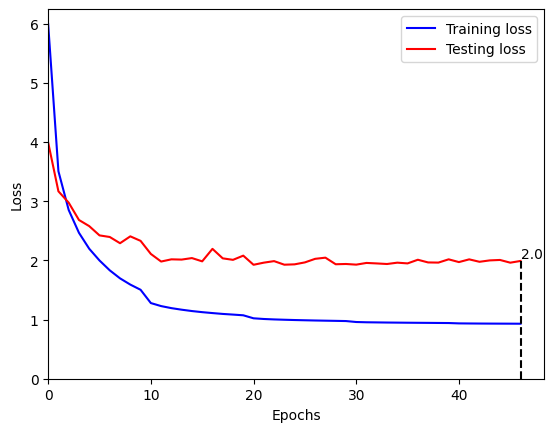

Traing epoch: 47   avg loss is: 0.9288705909057974
Validation epoch: 47   avg validation loss is: 1.9766471533939756
Validating on epoch: 47 has accuracy: top1: 78.22 top5: 91.39


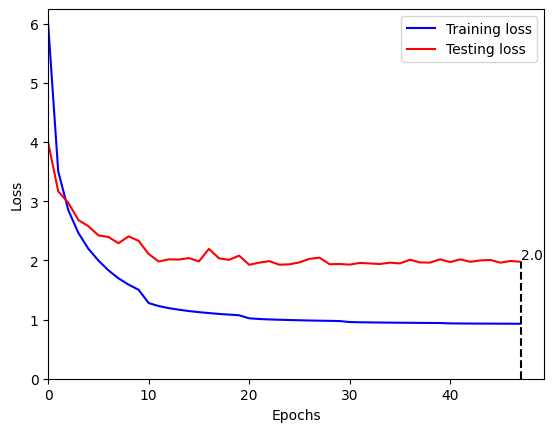

Traing epoch: 48   avg loss is: 0.9282183117823919
Validation epoch: 48   avg validation loss is: 1.988540984515486
Validating on epoch: 48 has accuracy: top1: 77.74 top5: 91.15


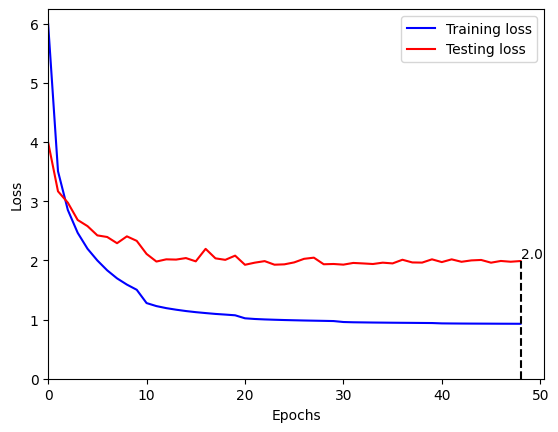

Traing epoch: 49   avg loss is: 0.9277632245355113
Validation epoch: 49   avg validation loss is: 2.0131740400708953
Validating on epoch: 49 has accuracy: top1: 77.60 top5: 91.05


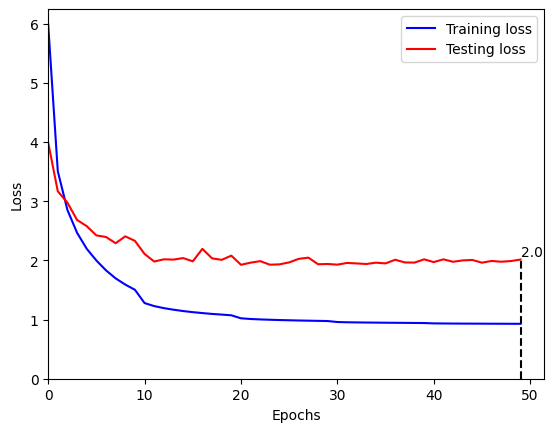

Traing epoch: 50   avg loss is: 0.9253141145652721
Validation epoch: 50   avg validation loss is: 2.011190496313161
Validating on epoch: 50 has accuracy: top1: 77.83 top5: 91.22


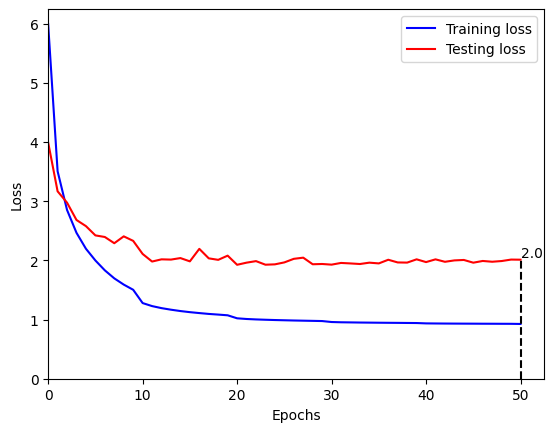

Traing epoch: 51   avg loss is: 0.9244155256003586
Validation epoch: 51   avg validation loss is: 1.9769989919662476
Validating on epoch: 51 has accuracy: top1: 78.48 top5: 91.27


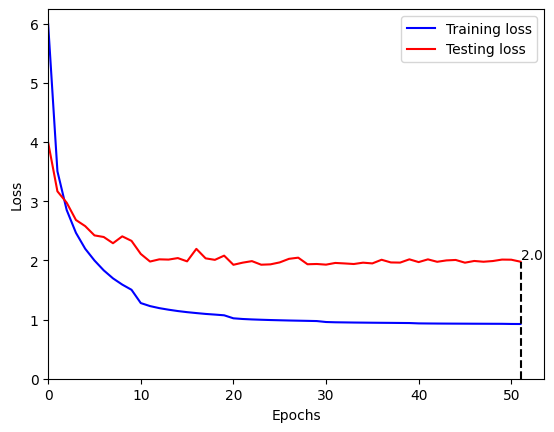

Traing epoch: 52   avg loss is: 0.9240881934185166
Validation epoch: 52   avg validation loss is: 1.9796603696099644
Validating on epoch: 52 has accuracy: top1: 78.78 top5: 91.55


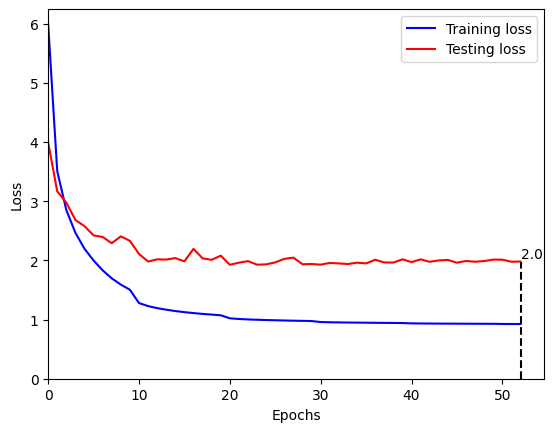

Traing epoch: 53   avg loss is: 0.9234538556377239
Validation epoch: 53   avg validation loss is: 1.9852945214304432
Validating on epoch: 53 has accuracy: top1: 78.75 top5: 91.46


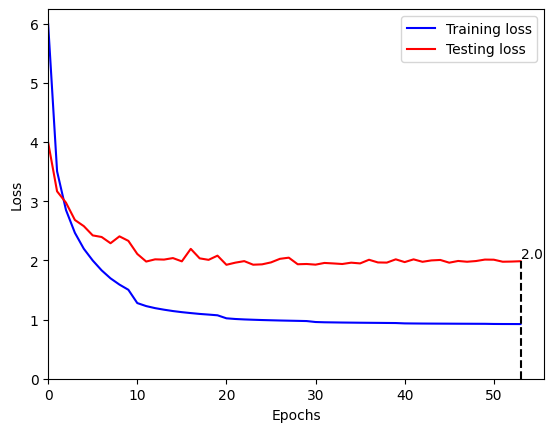

Traing epoch: 54   avg loss is: 0.9232606422694433
Validation epoch: 54   avg validation loss is: 1.97931732292833
Validating on epoch: 54 has accuracy: top1: 78.84 top5: 91.32


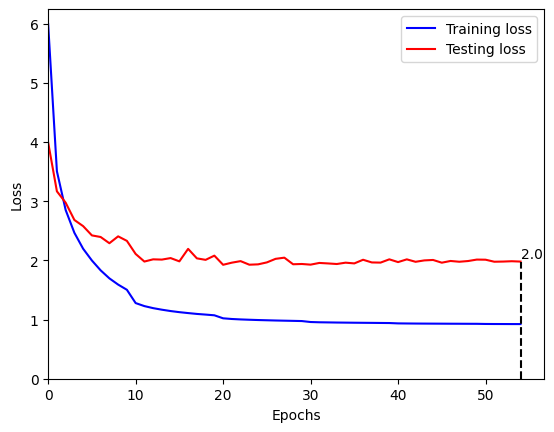

Traing epoch: 55   avg loss is: 0.9229289208199352
Validation epoch: 55   avg validation loss is: 1.987412970477137
Validating on epoch: 55 has accuracy: top1: 78.86 top5: 91.47


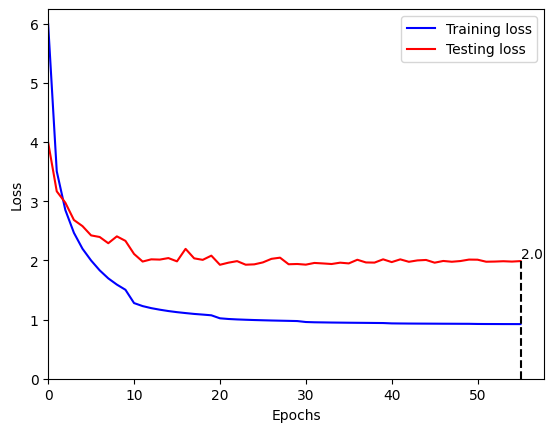

Traing epoch: 56   avg loss is: 0.9226066954166381
Validation epoch: 56   avg validation loss is: 1.9926660667616745
Validating on epoch: 56 has accuracy: top1: 78.45 top5: 91.24


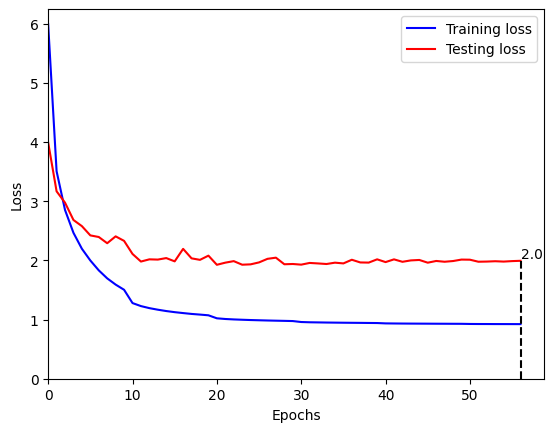

Traing epoch: 57   avg loss is: 0.9224641874242026
Validation epoch: 57   avg validation loss is: 1.9926857668777993
Validating on epoch: 57 has accuracy: top1: 78.22 top5: 91.39


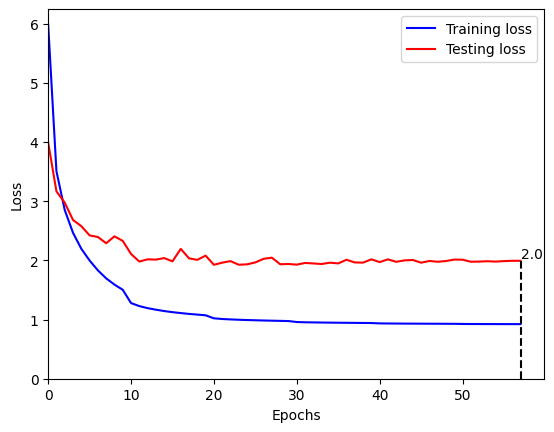

Traing epoch: 58   avg loss is: 0.9221131819876047
Validation epoch: 58   avg validation loss is: 2.001445853627961
Validating on epoch: 58 has accuracy: top1: 78.42 top5: 91.46


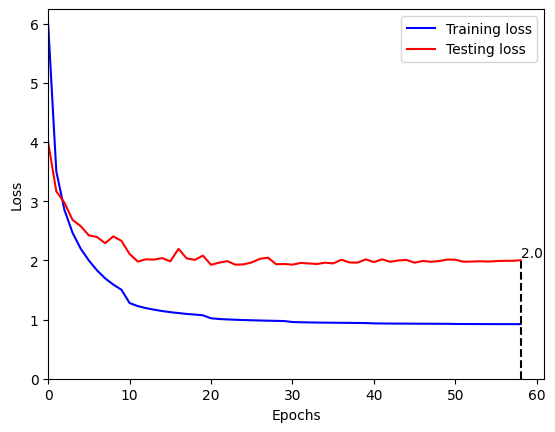

Traing epoch: 59   avg loss is: 0.9217658293583406
Validation epoch: 59   avg validation loss is: 1.9866416796322526
Validating on epoch: 59 has accuracy: top1: 78.56 top5: 91.29


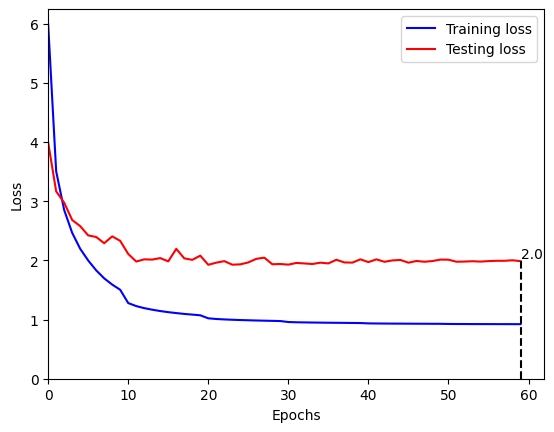

Traing epoch: 60   avg loss is: 0.9208103770089663
Validation epoch: 60   avg validation loss is: 1.9896112877747107
Validating on epoch: 60 has accuracy: top1: 78.78 top5: 91.54


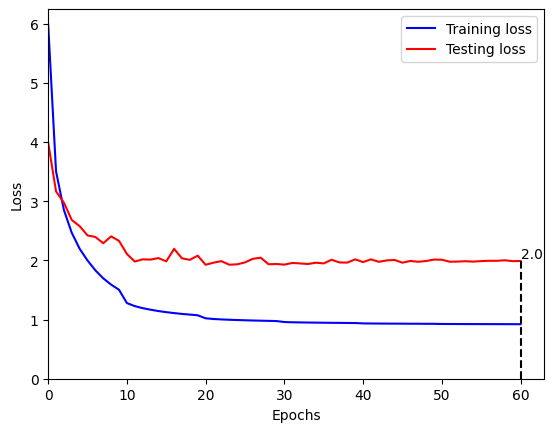

Traing epoch: 61   avg loss is: 0.9203769056073294
Validation epoch: 61   avg validation loss is: 1.987303428814329
Validating on epoch: 61 has accuracy: top1: 79.03 top5: 91.57


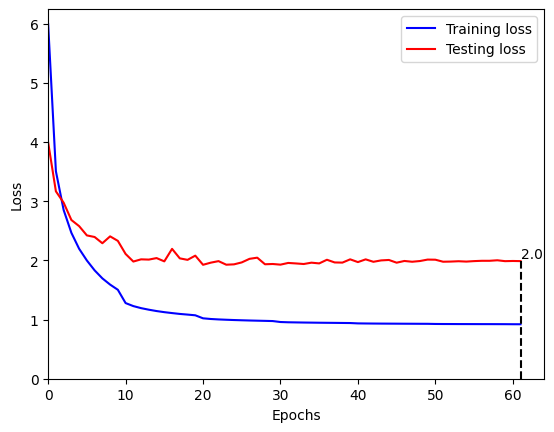

Traing epoch: 62   avg loss is: 0.9201999984682911
Validation epoch: 62   avg validation loss is: 2.002616375725845
Validating on epoch: 62 has accuracy: top1: 78.38 top5: 91.37


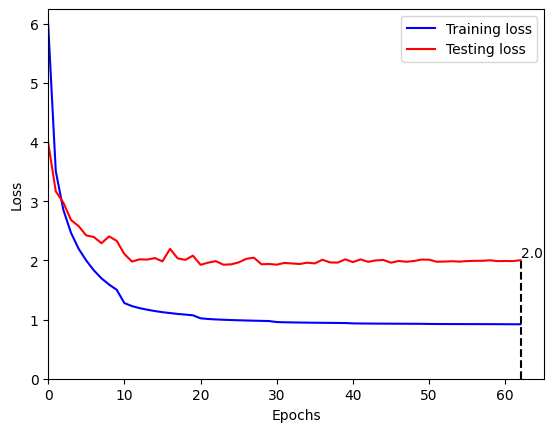

Traing epoch: 63   avg loss is: 0.9198956908330251
Validation epoch: 63   avg validation loss is: 2.0057907385661684
Validating on epoch: 63 has accuracy: top1: 78.38 top5: 91.42


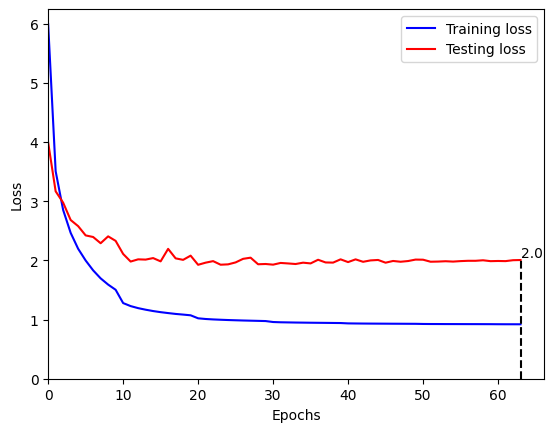

Traing epoch: 64   avg loss is: 0.9199120329983662
Validation epoch: 64   avg validation loss is: 2.0368387988518024
Validating on epoch: 64 has accuracy: top1: 77.93 top5: 91.07


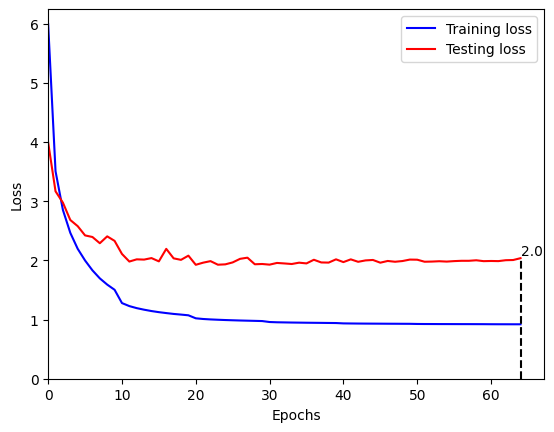

Traing epoch: 65   avg loss is: 0.9197146704410333
Validation epoch: 65   avg validation loss is: 2.012345716706638
Validating on epoch: 65 has accuracy: top1: 78.38 top5: 91.25


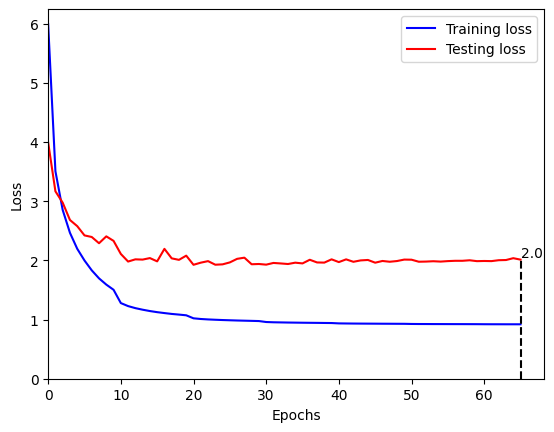

Traing epoch: 66   avg loss is: 0.9194680524177237
Validation epoch: 66   avg validation loss is: 1.9976051302613884
Validating on epoch: 66 has accuracy: top1: 78.57 top5: 91.48


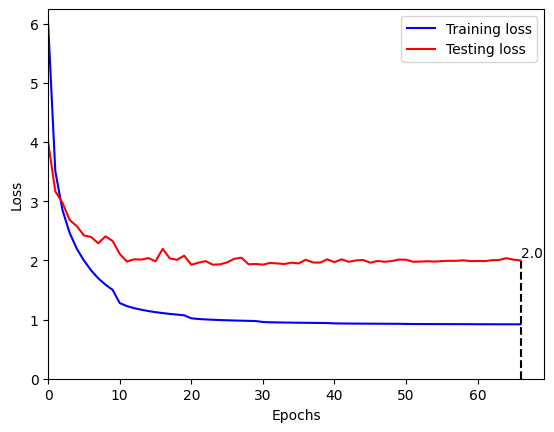

Traing epoch: 67   avg loss is: 0.919262830848597
Validation epoch: 67   avg validation loss is: 1.9895865372953743
Validating on epoch: 67 has accuracy: top1: 78.83 top5: 91.51


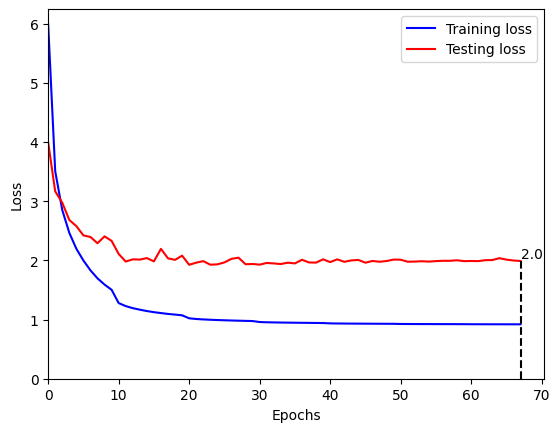

Traing epoch: 68   avg loss is: 0.9192099391338725
Validation epoch: 68   avg validation loss is: 1.99989246039555
Validating on epoch: 68 has accuracy: top1: 78.65 top5: 91.39


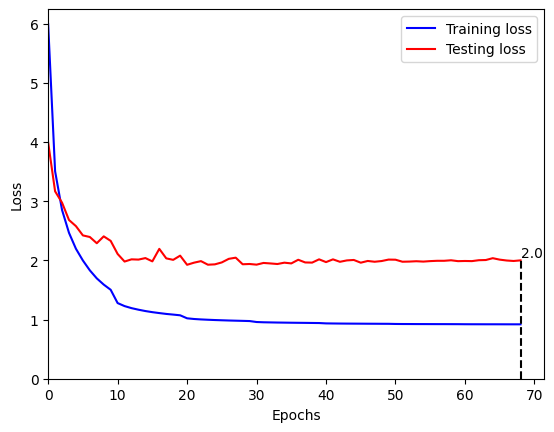

Traing epoch: 69   avg loss is: 0.9191138912759034
Validation epoch: 69   avg validation loss is: 2.002190676722033
Validating on epoch: 69 has accuracy: top1: 78.66 top5: 91.40


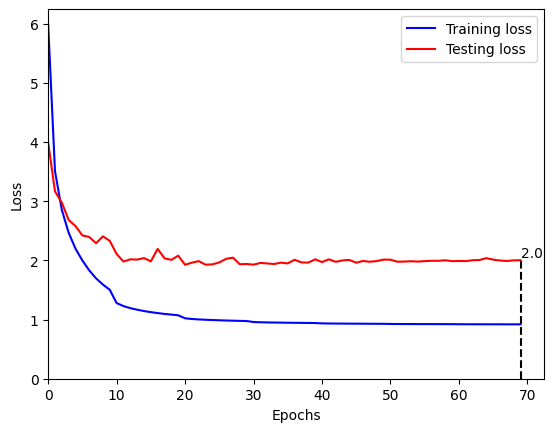

In [4]:
class DeepWriter_Train:
    def __init__(self,dataset='CERUG-EN',imgtype='png'):

        self.dataset = dataset
        self.folder = dataset
        #self.labelfolder = 'dataset/'

        if not os.path.exists(self.folder):
            if dataset == 'CERUG-EN':
                download_cerug(dataset)
            elif dataset == 'Firemaker':
                download_firemaker(dataset)
            else:
                print('****** Warning: the dataset %s does not existed!******'%dataset)
                print('Please go to the following website to check how to download the dataset:')
                print('https://www.ai.rug.nl/~sheng/writeridataset.html')
                print('*'*20)
                raise ValueError('Dataset: %s does not existed!'%dataset)

        self.labelfolder = self.folder
        
        source_folder = '/kaggle/input/firemaker-dataset/Firemaker Dataset/train/'
        destination_folder = '/kaggle/working/train/'
        
        copy_folder_contents(source_folder, destination_folder)
        
        
        #self.train_folder = self.folder+'/train/'
        self.train_folder = destination_folder

        transformer = ImageTransformer(foldername=self.train_folder)
        transformer.process_and_save_images()

        self.test_folder = '/kaggle/input/firemaker-dataset/Firemaker Dataset/holdout_set/'

        self.imgtype=imgtype
        self.device = 'cuda'
        self.scale_size=(64,128)

        if self.device == 'cuda':
            torch.backends.cudnn.benchmark = True

        if self.dataset == 'CVL':
            self.imgtype = 'tif'

        self.model_dir = 'model'
        if not os.path.exists(self.model_dir):
            #raise ValueError('Model directory: %s does not existed'%self.model_dir)
            os.mkdir(self.model_dir)#raise ValueError('Model directory: %s does not existed'%self.model_dir)

        #basedir = 'GRRNN_WriterIdentification_dataset_'+self.dataset+'_model_'+self.mode+'_aug_16'
        basedir = 'CTE_WriterIdentification_dataset_IAMCDAR_model_'
        self.logfile= basedir + '.log'
        self.modelfile = basedir
        self.batch_size = 16

        train_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.train_folder,
                        imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = True)

        self.training_data_loader = DataLoader(dataset=train_set, num_workers=2,
                           batch_size=self.batch_size, shuffle=True, drop_last=True)

        test_set = DatasetFromFolder(dataset=self.dataset,
        				labelfolder = self.labelfolder,
                        foldername=self.test_folder,imgtype=self.imgtype,
                        scale_size=self.scale_size,
                        is_training = False)

        self.testing_data_loader = DataLoader(dataset=test_set, num_workers=2,
                           batch_size=self.batch_size, shuffle=False)

        num_class = train_set.num_writer
        self.model = GrnnNet(1,num_classes=train_set.num_writer).to(self.device)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = LabelSomCE()
        self.optimizer = optim.Adam(self.model.parameters(),lr=0.0001,weight_decay=1e-4)
        self.scheduler = lr_scheduler.StepLR(self.optimizer,step_size=10,gamma=0.5)


    def train(self,epoch):
        self.model.train()
        losstotal = []

        for iteration,batch in enumerate(self.training_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].type(torch.long).to(self.device)

            self.optimizer.zero_grad()

            logits = self.model(inputs)

            train_loss= self.criterion(logits,target)

            losstotal.append(train_loss.item())
            train_loss.backward()
            self.optimizer.step()

        with open(self.logfile,'a') as fp:
            fp.write('Training epoch %d avg loss is: %.6f\n'%(epoch,np.mean(losstotal)))
        print('Traing epoch:',epoch,'  avg loss is:',np.mean(losstotal))


        return np.mean(losstotal)


    def test(self,epoch,during_train=True):
        self.model.eval()
        losstotal = []

        if not during_train:
            self.load_model(epoch)

        top1 = 0
        top5 = 0
        ntotal=0
        
        #all_preds = []
        #all_targets = []

        for iteration,batch in enumerate(self.testing_data_loader,1):
            inputs = batch[0].to(self.device).float()
            target = batch[1].to(self.device).long()

            logits = self.model(inputs)

            test_loss = self.criterion(logits,target)

            losstotal.append(test_loss.item())

            res = self.accuracy(logits,target,topk=(1,5))
            top1 += res[0]
            top5 += res[1]

            ntotal += inputs.size(0)
            
            #_, preds = logits.topk(1, 1, True, True)
            #all_preds.extend(preds.cpu().numpy().flatten())
            #all_targets.extend(target.cpu().numpy().flatten())



        top1 /= float(ntotal)
        top5 /= float(ntotal)
        
        #precision, recall, f1 = self.compute_metrics(all_preds, all_targets)

        print('Validation epoch:',epoch,'  avg validation loss is:',np.mean(losstotal))
        print('Validating on epoch: %d has accuracy: top1: %.2f top5: %.2f'%(epoch,top1*100,top5*100))
        #print('Precision: %.2f%%, Recall: %.2f%%, F1 Score: %.2f%%' % (precision * 100, recall * 100, f1 * 100))
        with open(self.logfile,'a') as fp:
            fp.write('Validating epoch %d accuracy is: top1: %.2f top5: %.2f\n'%(epoch,top1*100,top5*100))

        return np.mean(losstotal)



    def check_exists(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        return os.path.exists(model_out_path)

    def checkpoint(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        torch.save(self.model.state_dict(),model_out_path)


    def load_model(self,epoch):
        model_out_path = self.model_dir + '/' + self.modelfile + '-model_epoch_{}.pth'.format(epoch)
        self.model.load_state_dict(torch.load(model_out_path,map_location=self.device))
        print('Load model successful')

    def plot_losses(self, training_losses, testing_losses, csv_file_path="/kaggle/working/losses.csv"):
        indices = range(len(training_losses))
        plt.plot(indices, training_losses, 'b', label='Training loss')
        plt.plot(indices, testing_losses, 'r', label='Testing loss')
        #
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.xlim(left=0)
        plt.ylim(bottom=0)

        last_epoch = indices[-1]
        last_test_loss = testing_losses[-1]
        plt.plot([last_epoch, last_epoch], [0, last_test_loss], 'k--')
        plt.text(last_epoch, last_test_loss, f'{last_test_loss:.1f}', color='k', va='bottom', ha='left')
        plt.savefig("/kaggle/working/loss_plot.svg", format="svg", dpi=300)
        
        #plt.title('Training and Validation Losses')

        plt.show()
        
        with open(csv_file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['epoch', 'training_loss', 'testing_loss'])  
            for epoch, (train_loss, test_loss) in enumerate(zip(training_losses, testing_losses)):
                writer.writerow([epoch, train_loss, test_loss])

    def train_loops(self,start_epoch,num_epoch):
        #if self.check_exists(num_epoch): return
        if start_epoch > 0:
            self.load_model(start_epoch-1)

        training_losses = []
        testing_losses = []

        for epoch in range(start_epoch,num_epoch):
            train_loss = self.train(epoch)
            training_losses.append(train_loss)
            self.checkpoint(epoch)
            test_loss = self.test(epoch)
            testing_losses.append(test_loss)
            self.scheduler.step()
            self.plot_losses(training_losses, testing_losses)


    def accuracy(self,output,target,topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            _,pred = output.topk(maxk,1,True,True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.data.cpu().numpy())

        return res
    
    
    #def compute_metrics(self, preds, targets):
     #   precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='macro')
      #  return precision, recall, f1





if __name__ == '__main__':


    mod = DeepWriter_Train(dataset='/kaggle/input/firemaker-dataset/Firemaker Dataset')
    mod.train_loops(0,70)